<a href="https://colab.research.google.com/github/MNabegh/mlbd-project/blob/master/recommender_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os

path = 'lastfm-dataset-1K'

if not os.path.exists(path):

  !wget http://mtg.upf.edu/static/datasets/last.fm/lastfm-dataset-1K.tar.gz
  !tar -xvzf lastfm-dataset-1K.tar.gz


--2021-06-11 05:22:37--  http://mtg.upf.edu/static/datasets/last.fm/lastfm-dataset-1K.tar.gz
Resolving mtg.upf.edu (mtg.upf.edu)... 84.89.139.55
Connecting to mtg.upf.edu (mtg.upf.edu)|84.89.139.55|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 672741554 (642M) [application/x-gzip]
Saving to: ‘lastfm-dataset-1K.tar.gz’

lastfm-dataset-1K.t 100%[===================>] 641.58M  5.60MB/s    in 1m 57s  

2021-06-11 05:24:34 (5.49 MB/s) - ‘lastfm-dataset-1K.tar.gz’ saved [672741554/672741554]

lastfm-dataset-1K/
lastfm-dataset-1K/userid-profile.tsv
lastfm-dataset-1K/README.txt
lastfm-dataset-1K/userid-timestamp-artid-artname-traid-traname.tsv


In [1]:
!ls

sample_data


In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!ls drive/MyDrive/data

feature_df_with_emb_clean.csv  spotify_features_cleaned.csv
feature_df_with_emb.csv        spotify_features.csv
genres_3d_mapping.json	       spotify_uris.csv
genres_map.html		       topics_embedded.pkl
song_map.csv		       umap.csv
song_map_reduced.csv


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import scipy.sparse as sp
import tensorflow as tf
from tqdm import tqdm
import pandas as pd
import numpy as np

from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('seaborn')
%matplotlib inline

import datetime
import time 
import math
import os
%config Completer.use_jedi = False

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: Config option `use_jedi` not recognized by `IPCompleter`.


In [4]:
path = "drive/MyDrive/data/feature_df_with_emb_clean.csv"

feature_df_with_emb = pd.read_csv(path)
feature_df_with_emb = feature_df_with_emb.drop(columns=['Unnamed: 0', 'genres', 'genres_emb'])
feature_df_with_emb = feature_df_with_emb.dropna()

In [5]:
feature_df_with_emb.head()

,artist,track,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,popularity,emb_x,emb_y,emb_z
0,坂本龍一,Composition 0919 (Live_2009_4_15),0.806,0.413,5.0,-12.883,1.0,0.1560,0.987,0.794,0.1130,0.5290,105.089,330253.0,62,7.375277,4.894493,0.943493
1,坂本龍一,Hibari (Live_2009_4_15),0.604,0.283,9.0,-19.811,0.0,0.0583,0.996,0.916,0.1140,0.2700,137.802,540133.0,62,7.375277,4.894493,0.943493
2,坂本龍一,To Stanford (Live_2009_4_15),0.453,0.163,5.0,-20.922,1.0,0.0519,0.990,0.939,0.1010,0.0703,73.926,216853.0,39,7.375277,4.894493,0.943493
3,坂本龍一,Improvisation (Live_2009_4_15),0.217,0.012,5.0,-36.464,1.0,0.0376,0.991,0.859,0.0866,0.0376,80.714,384707.0,62,7.375277,4.894493,0.943493
4,坂本龍一,Glacier (Live_2009_4_15),0.518,0.213,9.0,-28.790,0.0,0.2090,0.869,0.898,0.1030,0.0920,104.191,580707.0,62,7.375277,4.894493,0.943493


In [6]:
feature_df_with_emb.isna().sum()

artist              0
track               0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
popularity          0
emb_x               0
emb_y               0
emb_z               0
dtype: int64

In [7]:
# Load the dataset
df = pd.read_table('lastfm-dataset-1K/userid-timestamp-artid-artname-traid-traname.tsv', lineterminator='\n', warn_bad_lines=True, names=['user', 'timestamp', 'artist-id', 'artist', 'song-id', 'song'])
df_profile = pd.read_csv('lastfm-dataset-1K/userid-profile.tsv', sep='\t', error_bad_lines=False, warn_bad_lines=True, skiprows=1, names=['user', 'gender', 'age', 'country', 'signup'])

In [8]:
# Check if some songs share a common ID
grouped = df[['song-id', 'song']].groupby(['song-id']).nunique()

In [9]:
# Get rows with song names containing multiple rows
duplicated = df.loc[df['song-id'].isin(grouped[grouped['song'] > 1].index)]
duplicated = duplicated.drop(columns=['user', 'timestamp', 'artist', 'artist-id'])
containis_extra_rows = duplicated.apply(lambda x: pd.Series({'id': x[0], 'song': x[1], 'flag':'\n' in x[1]}), axis=1)
containis_extra_rows = containis_extra_rows.loc[containis_extra_rows['flag']]

In [10]:
# Iterate over those 5k rows to get the extra rows and correct the song name
for index, row in containis_extra_rows.iterrows():
    row_break = row['song'].split('\n', 1)
    song_name = row_break[0]
    df.loc[df['song-id'] == row['id'], 'song'] = song_name
    
    tsv = StringIO(row_break[1])
    df_extra = pd.read_csv(tsv, sep="\t", warn_bad_lines=True, names=['user', 'timestamp', 'artist-id', 'artist', 'song-id', 'song'])
    df = df.append(df_extra, ignore_index=True)

### Fix names

In [11]:
# Check if some songs share a common ID
grouped = df[['song-id', 'song']].groupby(['song-id']).nunique()

In [12]:
# Check how many ids has more than 1 song name
grouped[grouped['song'] > 1].shape[0]

200

In [13]:
ids_to_be_fixed = grouped[grouped['song'] > 1].index

In [14]:
df = df.set_index('song-id')

In [15]:
map_to_fix = df.groupby(df.index)['song'].head(1)

In [16]:
df.loc[ids_to_be_fixed, 'song'] = df.loc[ids_to_be_fixed].reset_index()['song-id'].map(lambda x: map_to_fix[x])
df = df.reset_index()

### Create matrix

In [36]:
matrix_init = df.groupby(['user', 'artist', 'song']).count()

In [37]:
matrix_init = matrix_init['timestamp']
matrix_init = matrix_init.map(lambda x: np.log(x))

In [38]:
matrix_init = matrix_init.reset_index()

In [39]:
def rating_scaler(row):
    row_array = np.array(row)
    lower_bound, new_range= 2, 7
    min_, max_ = row_array.min(), row_array.max()
    old_range = max_ - min_
    
    
    scaled_row = (new_range * (row_array - min_)) / (old_range + 1e-6)  + lower_bound
    scaled_row[scaled_row == 2] = 0
    return pd.Series(scaled_row)

In [40]:
matrix_init_scaled = matrix_init.groupby('user')['timestamp'].apply(rating_scaler)

In [41]:
matrix_init['timestamp'] = matrix_init_scaled.reset_index()['timestamp']

In [42]:
matrix_init['timestamp'].describe()

count    4.613822e+06
mean     2.294305e+00
std      2.358462e+00
min      0.000000e+00
25%      0.000000e+00
50%      2.937382e+00
75%      4.201265e+00
max      8.999999e+00
Name: timestamp, dtype: float64

In [43]:
(matrix_init['timestamp'] == 0).sum() / matrix_init.shape[0]

0.47684197613171897

In [44]:
feature_df_with_emb['item'] = feature_df_with_emb.apply(lambda row: row[1]+' '+row[0], axis=1)

In [65]:
topics_df = pd.read_pickle('drive/MyDrive/data/topics_embedded.pkl')
topics_df[['topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6']] = pd.DataFrame(topics_df['topics'].tolist(), index= topics_df.index)
topics_df = topics_df.drop(columns=['Lyrics', 'Lyrics_en', 'topics'])
topics_df = topics_df.rename({'Song_Artist':'item'}, axis=1)

In [46]:
topics_df.head()

,Song_Artist,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6
220800,The Real Thing Kylie Minogue,0.908270,0.016006,0.015615,0.024251,0.019674,0.016184
220803,I Surrender The Adverts,0.082533,0.075666,0.303093,0.092924,0.151675,0.294109
220806,Woebegone Anneli Drecker,0.221403,0.041089,0.072499,0.088735,0.032662,0.543613
220807,Aina Nälkä Sielun Veljet,0.242173,0.342328,0.270193,0.018940,0.025390,0.100976
220808,Bla Bla Bla Toots & The Maytals,0.681251,0.119072,0.000000,0.017217,0.167817,0.000000


### Merge data

In [47]:
matrix_init = matrix_init.rename({'timestamp':'rating', 'song':'track'}, axis=1)

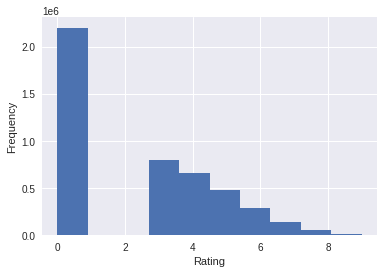

In [52]:
matrix_init['rating'].plot.hist()
plt.xlabel('Rating')
plt.savefig('drive/MyDrive/data/ratings_fig.eps', format='eps')
plt.show()

In [53]:
matrix_extended = matrix_init.merge(feature_df_with_emb, on=['artist', 'track'])

In [54]:
matrix_extended.head()

,user,artist,track,rating,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,popularity,emb_x,emb_y,emb_z,item
0,user_000001,2562,Basin Dub,3.142058,0.644,0.431,11.0,-7.676,1.0,0.206,0.0393,0.3,0.159,0.347,139.998,292769.0,19,5.311094,6.10387,3.313273,Basin Dub 2562
1,user_000451,2562,Basin Dub,3.080958,0.644,0.431,11.0,-7.676,1.0,0.206,0.0393,0.3,0.159,0.347,139.998,292769.0,19,5.311094,6.10387,3.313273,Basin Dub 2562
2,user_000471,2562,Basin Dub,0.000000,0.644,0.431,11.0,-7.676,1.0,0.206,0.0393,0.3,0.159,0.347,139.998,292769.0,19,5.311094,6.10387,3.313273,Basin Dub 2562
3,user_000508,2562,Basin Dub,3.976012,0.644,0.431,11.0,-7.676,1.0,0.206,0.0393,0.3,0.159,0.347,139.998,292769.0,19,5.311094,6.10387,3.313273,Basin Dub 2562
4,user_000515,2562,Basin Dub,2.973598,0.644,0.431,11.0,-7.676,1.0,0.206,0.0393,0.3,0.159,0.347,139.998,292769.0,19,5.311094,6.10387,3.313273,Basin Dub 2562


### Filter the dataset

In [55]:
matrix_extended.groupby('user').count()['rating'].describe()

count      991.000000
mean      3901.116044
std       4556.333601
min          3.000000
25%       1128.000000
50%       2654.000000
75%       4951.000000
max      58844.000000
Name: rating, dtype: float64

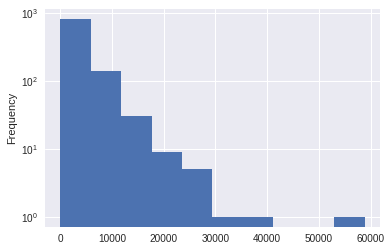

In [56]:
matrix_extended.groupby('user').count()['rating'].plot.hist()
plt.yscale('log')
plt.show()

In [57]:
matrix_extended.groupby('item').count()['rating'].describe()

count    750791.000000
mean          5.149244
std          11.747020
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max         346.000000
Name: rating, dtype: float64

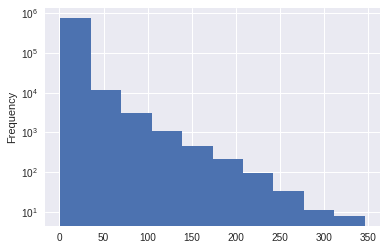

In [58]:
matrix_extended.groupby('item').count()['rating'].plot.hist()
plt.yscale('log')
plt.show()

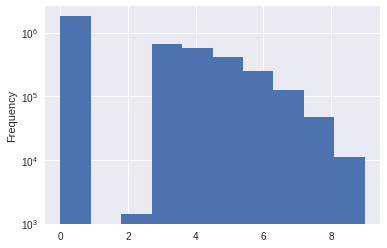

In [59]:
matrix_extended['rating'].plot.hist()
plt.yscale('log')
plt.show()Song_Artist

In [60]:
items_app = matrix_extended.groupby('item').count()['rating']
items_app = items_app.loc[items_app > 3.99].index
matrix_sampled = matrix_extended.copy()
matrix_sampled = matrix_sampled.set_index('item')
matrix_sampled = matrix_sampled.loc[items_app]
matrix_sampled = matrix_sampled.reset_index()
matrix_sampled = matrix_sampled.sample(frac=1)

In [61]:
matrix_sampled.groupby('user').count()['rating'].describe()

count      991.000000
mean      3130.442987
std       3484.796843
min          3.000000
25%        972.000000
50%       2182.000000
75%       3987.000000
max      44191.000000
Name: rating, dtype: float64

In [62]:
matrix_sampled.groupby('item').count()['rating'].describe()

count    217058.000000
mean         14.292350
std          18.938571
min           4.000000
25%           5.000000
50%           8.000000
75%          16.000000
max         346.000000
Name: rating, dtype: float64

In [66]:
matrix_sampled_merged = matrix_sampled.merge(topics_df, on='item')

### Sample Users

In [ ]:
# no_users = 200
# users_list = matrix_sampled.user.unique()
# users_sampled = np.random.choice(users_list, replace=False, size=no_users)
# matrix_sampled_agg = matrix_sampled.copy()
# matrix_sampled_agg = matrix_sampled_agg.set_index('user')
# matrix_sampled_agg = matrix_sampled_agg.loc[users_sampled]
# matrix_sampled_agg = matrix_sampled_agg.reset_index()
# matrix_sampled_agg = matrix_sampled_agg.sample(frac=1)

### Sample items


In [ ]:
# no_items = 10000
# items_app_count = matrix_sampled_agg.groupby('item').count()['rating'].reset_index()
# items_list = items_app_count.loc[items_app_count['rating'] > 8, 'item'].values
# items_sampled = np.random.choice(items_list, replace=False, size=no_items)
# matrix_sampled_agg = matrix_sampled_agg.set_index('item')
# matrix_sampled_agg = matrix_sampled_agg.loc[items_sampled]
# matrix_sampled_agg = matrix_sampled_agg.reset_index()
# matrix_sampled_agg = matrix_sampled_agg.sample(frac=1)

In [ ]:
matrix_sampled_merged['user_id'] = matrix_sampled_merged['user'].astype('category').cat.codes
matrix_sampled_merged['item_id'] = matrix_sampled_merged['item'].astype('category').cat.codes

In [ ]:
from random import choices
indices_to_upsample = matrix_sampled_agg.index[matrix_sampled_agg['rating'] > 8].tolist()
indices_upsampled = choices(indices_to_upsample, k=len(indices_to_upsample) * 10)
samples_df = matrix_sampled_agg.loc[indices_upsampled]
matrix_sampled_agg = pd.concat([matrix_sampled_agg, samples_df], axis=0)

In [ ]:
X = matrix_sampled_agg[['user_id', 
              'item_id',
              'danceability',
              'energy',
              'speechiness', 
              'acousticness', 
              'instrumentalness', 
              'liveness',
              'valence', 
              'tempo', 
              'popularity', 
              'emb_x', 
              'emb_y',
              'emb_z']]
y = matrix_sampled_agg['rating']
groups = matrix_sampled_agg['user_id']

In [ ]:
# Change splitting to be by index using https://stackoverflow.com/questions/53490497/getting-validation-set-from-train-set-by-using-percentage-from-groupby-in-pand
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=groups)

In [ ]:
no_users, no_items, no_factors = matrix_sampled_agg['user_id'].nunique(), matrix_sampled_agg['item_id'].nunique(), 100

In [ ]:
no_users

200

In [ ]:
no_items

10000

In [ ]:
X.shape

(198805, 14)

### Models

In [ ]:
def create_shallow_model(no_factors, no_users, no_items):
    # User branch
    user_id = tf.keras.layers.Input(shape=[1], name='user_id')
    user_matrix = tf.keras.layers.Embedding(no_users+1, no_factors, name='user_matrix')(user_id)
    user_vector = tf.keras.layers.Flatten(name='user_vector')(user_matrix)
    # Item branch
    item_id = tf.keras.layers.Input(shape=[1], name='item_id')
    item_matrix = tf.keras.layers.Embedding(no_items+1, no_factors, name='item_matrix')(item_id)
    item_vector = tf.keras.layers.Flatten(name='item_vector')(item_matrix)
    # Dot product 
    vectors_product = tf.keras.layers.dot([user_vector, item_vector], axes=1, normalize=False)
    # Model definition
    model = tf.keras.models.Model(inputs=[user_id, item_id], outputs=[vectors_product], name='shallow_model')
    return model

In [ ]:
model = create_shallow_model(no_factors, no_users, no_items)

In [ ]:
model.summary()

Model: "shallow_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_id (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_id (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_matrix (Embedding)         (None, 1, 100)       20100       user_id[0][0]                    
__________________________________________________________________________________________________
item_matrix (Embedding)         (None, 1, 100)       1000100     item_id[0][0]                    
______________________________________________________________________________________

In [ ]:
def create_deep_model(no_factors, no_users, no_items):
    all_input = tf.keras.layers.Input(shape=[14], name='input')
    input_reshaped = tf.keras.layers.Reshape((14,1), input_shape=(14,))(all_input)

    # Process input
    user_id_vec = tf.keras.layers.Cropping1D(cropping=(0,13))(input_reshaped)
    user_id = tf.keras.layers.Reshape((1,), input_shape=(1,1))(user_id_vec)

    item_id_vec = tf.keras.layers.Cropping1D(cropping=(1,12))(input_reshaped)
    item_id = tf.keras.layers.Reshape((1,), input_shape=(1,1))(item_id_vec)
    # User branch
    user_matrix = tf.keras.layers.Embedding(no_users+1, no_factors, name='user_matrix')(user_id)
    user_vector = tf.keras.layers.Flatten(name='user_vector')(user_matrix)
    # Item branch
    item_matrix = tf.keras.layers.Embedding(no_items+1, no_factors, name='item_matrix')(item_id)
    item_vector = tf.keras.layers.Flatten(name='item_vector')(item_matrix)
    # Concantenation
    vectors_concat = tf.keras.layers.Concatenate()([user_vector, item_vector])
    vectors_concat_dropout = tf.keras.layers.Dropout(0.2)(vectors_concat)
    # Backbone 
    dense_1 = tf.keras.layers.Dense(64,name='fc3')(vectors_concat_dropout)
    dropout_1 = tf.keras.layers.Dropout(0.2,name='d3')(dense_1)
    dense_2 = tf.keras.layers.Dense(32,name='fc4', activation='relu')(dropout_1)
    dropout_2 = tf.keras.layers.Dropout(0.2,name='d4')(dense_2)
    dense_3 = tf.keras.layers.Dense(16,name='fc5', activation='relu')(dropout_2)
    dropout_3 = tf.keras.layers.Dropout(0.2,name='d5')(dense_3)
    dense_4 = tf.keras.layers.Dense(8,name='fc6', activation='relu')(dropout_3)
    dense_4_output = tf.keras.layers.Dense(1, activation='relu', name='activation')(dense_4)
    # Model definition
    model = tf.keras.models.Model(inputs=[all_input], outputs=[dense_4_output], name='deep_model')
    return model

In [ ]:
def create_deep_hybird_model(no_factors, no_users, no_items):
    all_input = tf.keras.layers.Input(shape=[14], name='input')
    input_reshaped = tf.keras.layers.Reshape((14,1), input_shape=(14,))(all_input)

    # Process input
    user_id_vec = tf.keras.layers.Cropping1D(cropping=(0,13))(input_reshaped)
    user_id = tf.keras.layers.Reshape((1,), input_shape=(1,1))(user_id_vec)

    item_id_vec = tf.keras.layers.Cropping1D(cropping=(1,12))(input_reshaped)
    item_id = tf.keras.layers.Reshape((1,), input_shape=(1,1))(item_id_vec)

    metadata_vec = tf.keras.layers.Cropping1D(cropping=(2,0))(input_reshaped)
    metadata = tf.keras.layers.Reshape((12,), input_shape=(12,1))(metadata_vec)

    # User branch
    user_matrix = tf.keras.layers.Embedding(no_users+1, no_factors, name='user_matrix')(user_id)
    user_vector = tf.keras.layers.Flatten(name='user_vector')(user_matrix)
    # Item branch
    item_matrix = tf.keras.layers.Embedding(no_items+1, no_factors, name='item_matrix')(item_id)
    item_vector = tf.keras.layers.Flatten(name='item_vector')(item_matrix)
    # Concantenation
    vectors_concat = tf.keras.layers.Concatenate()([user_vector, item_vector])
    vectors_concat_dropout = tf.keras.layers.Dropout(0.2)(vectors_concat)
    # Preprocess metadata
    dense_meta_1 = tf.keras.layers.Dense(12,name='fc1')(metadata)
    dense_meta_2 = tf.keras.layers.Dense(8,name='fc2')(dense_meta_1)
    # Metadata concat
    vectors_concat_meta = tf.keras.layers.Concatenate() ([vectors_concat_dropout, dense_meta_2])
    # Backbone 
    dense_1 = tf.keras.layers.Dense(256,name='fc3')(vectors_concat_meta)
    dropout_1 = tf.keras.layers.Dropout(0.2,name='d3')(dense_1)
    dense_2 = tf.keras.layers.Dense(128,name='fc4', activation='relu')(dropout_1)
    dropout_2 = tf.keras.layers.Dropout(0.2,name='d4')(dense_2)
    dense_3 = tf.keras.layers.Dense(64,name='fc5', activation='relu')(dropout_2)
    dropout_3 = tf.keras.layers.Dropout(0.2,name='d5')(dense_3)
    dense_4 = tf.keras.layers.Dense(32,name='fc6', activation='relu')(dropout_3)
    dropout_4 = tf.keras.layers.Dropout(0.2,name='d6')(dense_4)
    dense_5 = tf.keras.layers.Dense(16,name='fc7', activation='relu')(dropout_4)
    dropout_5 = tf.keras.layers.Dropout(0.2,name='d7')(dense_5)
    dense_6 = tf.keras.layers.Dense(8,name='fc8', activation='relu')(dropout_5)    
    dense_6_output = tf.keras.layers.Dense(1, activation='relu', name='activation')(dense_6)
    # Model definition
    model = tf.keras.models.Model(inputs=[all_input], outputs=[dense_6_output], name='deep_model')
    return model

In [ ]:
model = create_deep_model(no_factors, no_users, no_items)

In [ ]:
model = create_deep_hybird_model(no_factors, no_users, no_items)
model.summary()

Model: "deep_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 14)]         0                                            
__________________________________________________________________________________________________
reshape_28 (Reshape)            (None, 14, 1)        0           input[0][0]                      
__________________________________________________________________________________________________
cropping1d_20 (Cropping1D)      (None, 1, 1)         0           reshape_28[0][0]                 
__________________________________________________________________________________________________
cropping1d_21 (Cropping1D)      (None, 1, 1)         0           reshape_28[0][0]                 
_________________________________________________________________________________________

### Model training

In [ ]:
# Input-output data definition
 
# X_train_arr = X_train.values.tolist()
# Try a decaying learning rate

# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-2,
#     decay_steps=1500,
#     decay_rate=0.9)

opt = tf.keras.optimizers.RMSprop()#learning_rate=lr_schedule)

# Model creation
model = create_deep_model(no_factors, no_users, no_items)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2, min_delta=0.2)

# Model compiling 
model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt)

# Model training
model.fit(X_train, y_train, epochs=10, callbacks=[callback], batch_size=2048, shuffle=True)

Epoch 1/10
78/78 [==============================] - 3s 21ms/step - loss: 14.1344
Epoch 2/10
78/78 [==============================] - 2s 21ms/step - loss: 8.5637
Epoch 3/10
78/78 [==============================] - 2s 21ms/step - loss: 8.1093
Epoch 4/10
78/78 [==============================] - 2s 21ms/step - loss: 7.8993
Epoch 5/10
78/78 [==============================] - 2s 21ms/step - loss: 7.7062
Epoch 6/10
78/78 [==============================] - 2s 21ms/step - loss: 7.6009
Epoch 7/10
78/78 [==============================] - 2s 21ms/step - loss: 7.5003
Epoch 8/10
78/78 [==============================] - 2s 20ms/step - loss: 7.3975
Epoch 9/10
78/78 [==============================] - 2s 20ms/step - loss: 7.3067
Epoch 10/10
78/78 [==============================] - 2s 20ms/step - loss: 7.1883


### Prediction

In [ ]:
# Predictions in the training set
# X_train = [X_train.user_id, X_train.item_id]
y_train_pred = model.predict(X_train, batch_size=2048)

In [ ]:
X_test.head()

,user_id,item_id,danceability,energy,speechiness,acousticness,instrumentalness,liveness,valence,tempo,popularity,emb_x,emb_y,emb_z
30149,25,8971,0.574,0.373,0.0271,0.522,0.000000,0.7010,0.327,104.884,67,5.298404,8.397001,1.453344
95190,95,2713,0.653,0.156,0.0343,0.753,0.000007,0.1930,0.194,108.170,64,5.330310,8.450220,1.451207
57594,171,9351,0.342,0.876,0.0428,0.018,0.000006,0.1710,0.788,169.844,48,5.607657,7.931748,1.640691
6262,70,3079,0.406,0.440,0.0391,0.767,0.235000,0.1600,0.143,78.559,58,5.752439,7.510446,2.268296
46742,107,9768,0.597,0.945,0.0497,0.018,0.000000,0.0654,0.939,147.908,74,5.032874,7.546081,3.659148


In [ ]:
# Predictions in the test set
# X_test_arr = [X_test.user_id, X_test.item_id]
y_test_pred = model.predict(X_test, batch_size=2048)

### Evaluation

In [ ]:
from sklearn.metrics import mean_squared_error
print('Train RMSE:', mean_squared_error(y_train.values, y_train_pred, squared=False))
print('Test RMSE:', mean_squared_error(y_test.values, y_test_pred, squared=False))

Train RMSE: 2.682631526505881
Test RMSE: 2.8435104530632596


In [ ]:
def get_test_predictions(model, X_test):
  predictions_li = []
  for user_id, test_user in tqdm(X_test.groupby('user_id'), position=0, leave=True):    
    # Retrieve the unseen items
    user_df = test_user[['item_id', 'rating']].copy()
    test_pids = user_df['item_id'].values
    relevant_pids = set(user_df.loc[user_df['rating'] > 1, 'item_id'].values)
    if len(relevant_pids) == 0:
      continue
    # Make rating predictions for all items for that user
    predictions = model.predict(test_user.drop(columns=['rating']), batch_size=2048)
    # predictions = pred_func(model, user_id, pid_array, train_ratings)
    predictions = predictions.reshape(-1)
    irrelevant_pids = set(test_pids).difference(relevant_pids)
    predictions_relevant = predictions[user_df['rating'] > 2]
    predictions_irrelevant = predictions[user_df['rating'] == 0]
    predictions_dict = {'user_id': user_id,
                        'predictions': predictions,
                        'test_pids': test_pids,
                        'relevant_pids': relevant_pids,
                        'irrelevant_pids': irrelevant_pids,
                        'predictions_relevant': predictions_relevant,
                        'predictions_irrelevant': predictions_irrelevant}
    predictions_li.append(predictions_dict)

  return pd.DataFrame(predictions_li)


In [ ]:
X_test.head()

,user_id,item_id,danceability,energy,speechiness,acousticness,instrumentalness,liveness,valence,tempo,popularity,emb_x,emb_y,emb_z
30149,25,8971,0.574,0.373,0.0271,0.522,0.000000,0.7010,0.327,104.884,67,5.298404,8.397001,1.453344
95190,95,2713,0.653,0.156,0.0343,0.753,0.000007,0.1930,0.194,108.170,64,5.330310,8.450220,1.451207
57594,171,9351,0.342,0.876,0.0428,0.018,0.000006,0.1710,0.788,169.844,48,5.607657,7.931748,1.640691
6262,70,3079,0.406,0.440,0.0391,0.767,0.235000,0.1600,0.143,78.559,58,5.752439,7.510446,2.268296
46742,107,9768,0.597,0.945,0.0497,0.018,0.000000,0.0654,0.939,147.908,74,5.032874,7.546081,3.659148


In [ ]:
# X_test_arr = np.array(X_test_arr)
# test_ratings = pd.DataFrame({'user_id': X_test_arr[0, :], 'item_id':X_test_arr[1, :], 'rating': y_test})
X_test_copy = X_test.copy()
X_test_copy['rating'] = y_test 
predictions_df = get_test_predictions(model, X_test_copy)

100%|██████████| 200/200 [00:12<00:00, 15.53it/s]


In [ ]:
def plot_predictions(predictions_df):
  pred_arr = [predictions_df[['predictions_relevant']].apply(lambda x: np.hstack(x), axis=0).values.reshape(-1),
              predictions_df[['predictions_irrelevant']].apply(lambda x: np.hstack(x), axis=0).values.reshape(-1)]

  f, ax = plt.subplots(1, 1)
  ax.set_title('Predictions distribution', color='C0')
  c = 'red'
  bplot = plt.boxplot(pred_arr, labels=['Relevant', 'Irrelevant'], vert=True, patch_artist=True)
  # fill with colors
  colors = ['C4', 'C2']
  for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

  for median in bplot['medians']:
    median.set(color='k', linewidth=1.5)

  plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


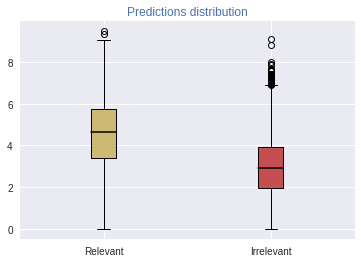

In [ ]:
plot_predictions(predictions_df)

In [ ]:
def precision_at_k(predictions_df):
    precisions = []
    # For each user
    for row in predictions_df.iterrows():
      predictions = row[1][1]
      test_pids = row[1][2]
      relevant_pids = set(row[1][3])
      if len(relevant_pids) == 0:
          continue
      # Sort the items and het the top k
      top_k = predictions > 4
      if top_k.sum() == 0:
         precisions.append(0)
         continue
      top_k_items = set(np.array(test_pids)[top_k])
      # Compute precision as per definition
      precisions.append(len(top_k_items & relevant_pids) / top_k.sum())
    return precisions

In [ ]:
precisions = precision_at_k(predictions_df)

In [ ]:
np.mean(precisions), np.std(precisions)

(0.47017469804377693, 0.24089932144399276)

In [ ]:
### EXERCISE CELL ###
def recall_at_k(predictions_df):
    recalls = []
    # For each user
    for row in predictions_df.iterrows():
      predictions = row[1][1]
      test_pids = row[1][2]
      relevant_pids = set(row[1][3])
      if len(relevant_pids) == 0:
          continue
      # Sort the items and het the top k
      top_k = predictions > 3
      if top_k.sum() == 0:
         recalls.append(0)
         continue
      top_k_items = set(np.array(test_pids)[top_k])
      recalls.append(len(top_k_items & relevant_pids) / len(relevant_pids))
    return recalls

In [ ]:
recalls = recall_at_k(predictions_df)

In [ ]:
np.mean(recalls), np.std(recalls)

(0.6526263202087391, 0.3132352010659319)

In [ ]:
### EXERCISE CELL ###
def map_at_k(predictions_df, k=100):
    maps = []
    for row in predictions_df.iterrows():
      predictions = row[1][1]
      test_pids = row[1][2]
      relevant_pids = set(row[1][3])
      if len(relevant_pids) == 0:
          continue
      partial_maps = []
      top_k = list(np.argsort(predictions)[:k])
      top_k_items = np.array(test_pids)[top_k]
      for rank, item_id in enumerate(top_k_items):
          if item_id in relevant_pids:
              partial_maps.append(len(set(top_k_items[:rank+1]) & relevant_pids) / float(rank+1))
      maps.append(.0 if len(partial_maps) == 0 else np.sum(partial_maps) / float(k))
    return maps

In [ ]:
maps = map_at_k(predictions_df, k=100)

In [ ]:
np.mean(maps), np.std(maps)

(0.25508051186679687, 0.20274048664308122)